# Descarga del Dataset

In [ ]:
import sys, subprocess, pkgutil

def pip_install(pkgs):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

req = ["pandas","numpy","scikit-learn","matplotlib","nltk","gensim","textdistance","spacy","datasets"]
to_install = [p for p in req if pkgutil.find_loader(p) is None]
if to_install:
    pip_install(to_install)

try:
    import es_core_news_sm
except Exception:
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "es_core_news_sm"])

import nltk
try:
    nltk.data.find("corpora/stopwords")
except LookupError:
    nltk.download("stopwords")

print("OK: dependencias listas.")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\caste\AppData\Roaming\nltk_data...


OK: dependencias listas.


[nltk_data]   Unzipping corpora\stopwords.zip.


In [ ]:
import pandas as pd, os

os.makedirs("data/raw", exist_ok=True)
df = pd.read_csv("data/raw/data.csv")

print("Columnas:", df.columns.tolist())
text_candidates  = [c for c in ["text","content","article","body","news","texto"] if c in df.columns]
label_candidates = [c for c in ["label","category","topic","class","etiqueta"] if c in df.columns]

if not text_candidates or not label_candidates:
    raise ValueError("No encuentro columnas de texto/etiqueta. Dime qué columnas trae y lo ajusto.")

TEXT_COL  = text_candidates[0]
LABEL_COL = label_candidates[0]

out = df[[TEXT_COL, LABEL_COL]].rename(columns={TEXT_COL:"text", LABEL_COL:"label"})
out.to_csv("data/raw/dataset.csv", index=False)
print("Listo -> data/raw/dataset.csv", out.shape)
print(out.head(3))

Columnas: ['language', 'category', 'newspaper', 'hash', 'text']
Listo -> data/raw/dataset.csv (10200, 2)
                                                text label
0  Valladolid misteriosa es el título del nuevo l...  play
1  El coraje de ser, de Mónica Cavallé, la aventu...  play
2  En la Tercera el francés, de Federico Supervie...  play


# Preprocesamiento

In [ ]:
import sys, subprocess, pkgutil

def ensure(pkg, pip_name=None):
    pip_name = pip_name or pkg
    if pkgutil.find_loader(pkg) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip_name])

ensure("pandas")
ensure("numpy")
ensure("nltk")
ensure("textdistance")
try:
    ensure("spacy")
    import spacy
    try:
        import es_core_news_sm 
        nlp = es_core_news_sm.load()
    except Exception:
        subprocess.check_call([sys.executable, "-m", "spacy", "download", "es_core_news_sm"])
        import es_core_news_sm
        nlp = es_core_news_sm.load()
except Exception:
    nlp = None

import nltk
try:
    nltk.data.find("corpora/stopwords")
except LookupError:
    nltk.download("stopwords")

print("OK deps. spaCy:", "on" if nlp else "off")

OK deps. spaCy: on


In [ ]:
import pandas as pd, os

path = "data/raw/dataset.csv"  
df = pd.read_csv(path)
assert {"text","label"}.issubset(df.columns), df.columns.tolist()

df = df.dropna(subset=["text"]).reset_index(drop=True)
print(df.shape)
df.head(3)

(10200, 2)


,text,label
0,Valladolid misteriosa es el título del nuevo l...,play
1,"El coraje de ser, de Mónica Cavallé, la aventu...",play
2,"En la Tercera el francés, de Federico Supervie...",play


In [ ]:
import re, unicodedata
from nltk.corpus import stopwords

SPANISH_SW = set(stopwords.words("spanish"))

def normalize(txt:str)->str:
    txt = txt.lower()
    txt = "".join(c for c in unicodedata.normalize("NFD", txt) if unicodedata.category(c) != "Mn")
    txt = re.sub(r"[\r\n\t]+"," ", txt)
    txt = re.sub(r"\s+"," ", txt).strip()
    return txt

def tokenize_simple(txt:str):
    return re.findall(r"\b\w+\b", txt, flags=re.UNICODE)

def clean_tokens(tokens, remove_digits=True, remove_sw=True):
    out=[]
    for t in tokens:
        if remove_digits and t.isdigit(): 
            continue
        if remove_sw and t in SPANISH_SW:
            continue
        out.append(t)
    return out

In [ ]:
df["text_norm"] = df["text"].map(normalize)
df["tokens"] = df["text_norm"].map(tokenize_simple).map(clean_tokens)

print(df[["text", "text_norm"]].head(2))
print("Ejemplo tokens:", df["tokens"].iloc[0][:20])

                                                text  \
0  Valladolid misteriosa es el título del nuevo l...   
1  El coraje de ser, de Mónica Cavallé, la aventu...   

                                           text_norm  
0  valladolid misteriosa es el titulo del nuevo l...  
1  el coraje de ser, de monica cavalle, la aventu...  
Ejemplo tokens: ['valladolid', 'misteriosa', 'titulo', 'nuevo', 'libro', 'acaba', 'publicar', 'editorial', 'almuzara', 'trata', 'obra', 'investigador', 'paranormal', 'juan', 'carlos', 'pasalodos', 'perez', 'realiza', 'exhaustiva', 'recopilacion']


In [ ]:
from nltk.stem.snowball import SpanishStemmer
stemmer = SpanishStemmer()

df["stems"] = df["tokens"].map(lambda toks: [stemmer.stem(t) for t in toks])

if nlp is not None:
    def lemmatize_list(toks):
        doc = nlp(" ".join(toks))
        return [t.lemma_ if t.lemma_ else t.text for t in doc]
    df["lemmas"] = df["tokens"].map(lemmatize_list)
else:
    df["lemmas"] = df["tokens"] 

df[["tokens","stems","lemmas"]].head(2)

,tokens,stems,lemmas
0,"[valladolid, misteriosa, titulo, nuevo, libro,...","[valladol, misteri, titul, nuev, libr, acab, p...","[valladolid, misterioso, titulo, nuevo, libro,..."
1,"[coraje, ser, monica, cavalle, aventura, autoc...","[coraj, ser, monic, cavall, aventur, autoconoc...","[coraje, ser, monicar, cavalle, aventura, auto..."


In [ ]:
from collections import Counter
import textdistance

vocab = Counter(t for toks in df["tokens"] for t in toks)
rare = [w for w,c in vocab.items() if c==1][:100]    
cand = set([w for w,c in vocab.items() if c>=5])      

def suggest(word, candidates, max_dist=1):
    return [c for c in candidates if textdistance.levenshtein.distance(word, c) <= max_dist]

for w in rare[:10]:
    s = suggest(w, cand, max_dist=1)
    if s:
        print(f"{w} -> {s[:5]}")

arcanos -> ['arcano']
asentamos -> ['sentamos', 'asentados']
yoes -> ['oes', 'goes', 'yves', 'does']
llenados -> ['llegados', 'llenamos', 'llenado', 'llevados']
azores -> ['amores']


In [ ]:
os.makedirs("data/processed", exist_ok=True)
df.to_parquet("data/processed/preprocesado.parquet", index=False)
print("OK → data/processed/preprocesado.parquet")

OK → data/processed/preprocesado.parquet


# Representaciones

In [1]:
import sys, subprocess, pkgutil, os

def ensure(pkg, pip_name=None):
    pip_name = pip_name or pkg
    if pkgutil.find_loader(pkg) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip_name])

ensure("pandas")
ensure("numpy")
ensure("scikit-learn", "scikit-learn")
ensure("gensim")
ensure("matplotlib")

import numpy as np, pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

os.makedirs("figures", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("data/processed", exist_ok=True)

print("OK imports.")


OK imports.


In [2]:
df = pd.read_parquet("data/processed/preprocesado.parquet")
texts  = df["text_norm"].tolist()
tokens = df["tokens"].tolist()
len(texts), len(tokens), type(tokens[0])[:5]

(10200, 10200, numpy.ndarray[slice(None, 5, None)])

In [ ]:
bow = CountVectorizer(ngram_range=(1,1))          
tfidf = TfidfVectorizer(ngram_range=(1,2))        

X_bow   = bow.fit_transform(texts)
X_tfidf = tfidf.fit_transform(texts)

print("BoW:",   X_bow.shape,   "Voc:", len(bow.vocabulary_))
print("TF-IDF:", X_tfidf.shape, "Voc:", len(tfidf.vocabulary_))

import joblib
joblib.dump(bow,   "models/bow_vectorizer.joblib")
joblib.dump(tfidf, "models/tfidf_vectorizer.joblib")

BoW: (10200, 157587) Voc: 157587
TF-IDF: (10200, 1921725) Voc: 1921725


['models/tfidf_vectorizer.joblib']

In [ ]:
import numpy as np, pickle, os, ast
from collections import Counter

if isinstance(tokens[0], str):
    tokens = [ast.literal_eval(t) for t in tokens]

def cooc_matrix(tokenized_docs, window=4, min_count=5, top_k=None):
    vocab_counts = Counter(t for doc in tokenized_docs for t in doc)
    items = [(w,c) for w,c in vocab_counts.items() if c >= min_count]
    if top_k is not None and len(items) > top_k:
        items = sorted(items, key=lambda x: -x[1])[:top_k]
    idx = {w:i for i,(w,_) in enumerate(sorted(items, key=lambda x: -x[1]))}
    V = len(idx)
    C = np.zeros((V, V), dtype=np.float32)
    for doc in tokenized_docs:
        L = len(doc)
        for i, t in enumerate(doc):
            if t not in idx: 
                continue
            wi = idx[t]
            left = max(0, i - window)
            right = min(L, i + window + 1)
            for u in doc[left:i]:
                if u in idx:
                    C[wi, idx[u]] += 1.0
            for u in doc[i+1:right]:
                if u in idx:
                    C[wi, idx[u]] += 1.0
    return C, idx

def ppmi(C, eps=1e-8):
    total = C.sum()
    if total == 0:
        return C
    pi = C.sum(axis=1, keepdims=True)
    pj = C.sum(axis=0, keepdims=True)
    pij = C / (total + eps)
    denom = (pi @ pj) / (total**2 + eps)
    with np.errstate(divide='ignore'):
        pmi = np.log((pij + eps) / (denom + eps))
    return np.maximum(0.0, pmi)

C, idx = cooc_matrix(tokens, window=4, min_count=5, top_k=20000)
X_ppmi = ppmi(C)

print("Co-ocurrencias:", C.shape, "| PPMI:", X_ppmi.shape, "| Vocab:", len(idx))

os.makedirs("data/processed", exist_ok=True)
np.save("data/processed/cooc.npy", C)
np.save("data/processed/ppmi.npy", X_ppmi)
with open("data/processed/cooc_idx.pkl", "wb") as f:
    pickle.dump(idx, f)
print("OK → cooc/ppmi guardados.")

Co-ocurrencias: (20000, 20000) | PPMI: (20000, 20000) | Vocab: 20000
OK → cooc/ppmi guardados.


In [ ]:
# Celda 5 (FIX) — Word2Vec robusto + progreso + guardado
import os, numpy as np
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

def clean_docs(docs, min_len=2):
    ok = []
    for doc in docs:
        if isinstance(doc, str):
            seq = doc.split()
        elif isinstance(doc, (list, tuple)):
            seq = list(doc)
        else:
            try:
                seq = list(doc)
            except Exception:
                continue
        clean = []
        for t in seq:
            if t is None:
                continue
            if isinstance(t, (list, tuple, np.ndarray, dict, set)):
                continue
            s = str(t).strip()
            if s:
                clean.append(s)
        if len(clean) >= min_len:
            ok.append(clean)
    return ok

tokens_clean = clean_docs(tokens, min_len=2)
print("Docs totales:", len(tokens), "| docs válidos:", len(tokens_clean))
print("Ejemplo doc:", tokens_clean[0][:12])

class EpochLogger(CallbackAny2Vec):
    def __init__(self): self.epoch = 0
    def on_epoch_begin(self, model): 
        print(f"▶️  epoch {self.epoch+1}/{model.epochs}")
    def on_epoch_end(self, model):
        if model.compute_loss:
            print(f"   loss acumulado: {model.get_latest_training_loss():.1f}")
        self.epoch += 1

w2v = Word2Vec(
    vector_size=100, window=5, min_count=5,
    workers=2, sg=1, epochs=5, seed=42,
    compute_loss=True
)

w2v.build_vocab(tokens_clean, progress_per=10000)
print("Vocab size:", len(w2v.wv))

w2v.train(
    corpus_iterable=tokens_clean,
    total_examples=w2v.corpus_count,
    epochs=w2v.epochs,
    report_delay=10,
    callbacks=[EpochLogger()]
)

def doc_avg_vecs(tokenized_docs, model):
    dim = model.wv.vector_size
    out = []
    for doc in tokenized_docs:
        vecs = [model.wv[w] for w in doc if w in model.wv]
        out.append(np.mean(vecs, axis=0) if len(vecs) else np.zeros(dim))
    return np.vstack(out)

X_w2v = doc_avg_vecs(tokens_clean, w2v)
print("Doc-embeddings:", X_w2v.shape)

os.makedirs("models", exist_ok=True)
os.makedirs("data/processed", exist_ok=True)
w2v.save("models/word2vec.model")
np.save("data/processed/doc_embeddings_w2v.npy", X_w2v)
print("OK → models/word2vec.model y data/processed/doc_embeddings_w2v.npy")

Docs totales: 10200 | docs válidos: 10200
Ejemplo doc: ['valladolid', 'misteriosa', 'titulo', 'nuevo', 'libro', 'acaba', 'publicar', 'editorial', 'almuzara', 'trata', 'obra', 'investigador']
Vocab size: 50606
▶️  epoch 1/5
▶️  epoch 2/5
▶️  epoch 3/5
▶️  epoch 4/5
▶️  epoch 5/5
Doc-embeddings: (10200, 100)
OK → models/word2vec.model y data/processed/doc_embeddings_w2v.npy


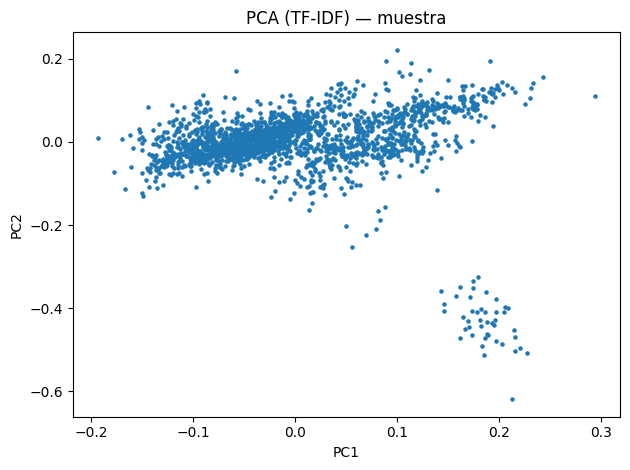

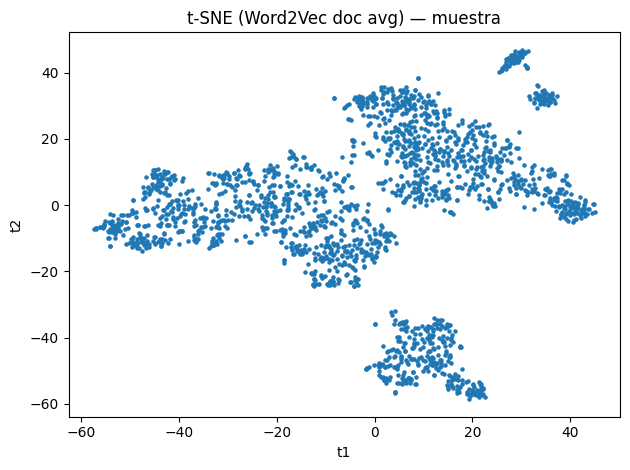

Figuras guardadas en ./figures/


In [ ]:
n1 = min(2000, X_tfidf.shape[0])
n2 = min(2000, X_w2v.shape[0])

X_tfidf_sample = X_tfidf[:n1].toarray()
pca = PCA(n_components=2, random_state=42).fit_transform(X_tfidf_sample)
plt.figure()
plt.scatter(pca[:,0], pca[:,1], s=5)
plt.title("PCA (TF-IDF) — muestra")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout(); plt.savefig("figures/pca_tfidf.png", dpi=160)
plt.show()

tsne = TSNE(n_components=2, perplexity=30, random_state=42, init="random").fit_transform(X_w2v[:n2])
plt.figure()
plt.scatter(tsne[:,0], tsne[:,1], s=5)
plt.title("t-SNE (Word2Vec doc avg) — muestra")
plt.xlabel("t1"); plt.ylabel("t2")
plt.tight_layout(); plt.savefig("figures/tsne_w2v.png", dpi=160)
plt.show()

print("Figuras guardadas en ./figures/")

In [ ]:
print({
    "bow_shape":   tuple(X_bow.shape),
    "tfidf_shape": tuple(X_tfidf.shape),
    "ppmi_shape":  tuple(X_ppmi.shape),
    "w2v_docs":    X_w2v.shape[0],
    "w2v_dim":     X_w2v.shape[1],
})

{'bow_shape': (10200, 157587), 'tfidf_shape': (10200, 1921725), 'ppmi_shape': (20000, 20000), 'w2v_docs': 10200, 'w2v_dim': 100}


# N-gramas

In [ ]:
import pandas as pd, ast

df = pd.read_parquet("data/processed/preprocesado.parquet")
tokens = df["tokens"].tolist()

if isinstance(tokens[0], str):
    tokens = [ast.literal_eval(t) for t in tokens]

len(tokens), tokens[0][:12]

(10200,
 array(['valladolid', 'misteriosa', 'titulo', 'nuevo', 'libro', 'acaba',
        'publicar', 'editorial', 'almuzara', 'trata', 'obra',
        'investigador'], dtype=object))

In [9]:
from collections import Counter
from sklearn.model_selection import train_test_split

train_sents, test_sents = train_test_split(tokens, test_size=0.1, random_state=42)

BOS, EOS, UNK = "<s>", "</s>", "<unk>"

def build_vocab(sents, min_count=3):
    cnt = Counter(w for s in sents for w in s)
    vocab = {w for w,c in cnt.items() if c >= min_count}
    vocab |= {BOS, EOS, UNK}
    return vocab

def apply_vocab(sents, vocab):
    out = []
    for s in sents:
        s2 = [w if w in vocab else UNK for w in s]
        out.append(s2)
    return out

vocab = build_vocab(train_sents, min_count=3)
train_sents = apply_vocab(train_sents, vocab)
test_sents  = apply_vocab(test_sents,  vocab)

len(vocab), len(train_sents), len(test_sents)

(65835, 9180, 1020)

In [10]:
from collections import Counter

def add_boundaries(sents, n):
    out=[]
    for s in sents:
        out.append([BOS]*(n-1) + s + [EOS])
    return out

def ngram_counts(sents, n):
    sents_b = add_boundaries(sents, n)
    counts = Counter()
    ctx_counts = Counter()
    for s in sents_b:
        for i in range(n-1, len(s)):
            ngram = tuple(s[i-n+1:i+1])
            ctx   = ngram[:-1]
            counts[ngram] += 1
            ctx_counts[ctx] += 1
    return counts, ctx_counts

c2, cx2 = ngram_counts(train_sents, 2)
len(c2), len(cx2), list(c2.most_common(3))[:3]

(1961943,
 65834,
 [(('<unk>', '<unk>'), 10123),
  (('millones', 'euros'), 1519),
  (('puede', 'ser'), 1210)])

In [11]:
import math

def sent_log2prob(sent, n, counts, ctx_counts, V, k=1.0):
    s = [BOS]*(n-1) + sent + [EOS]
    log2p=0.0
    for i in range(n-1, len(s)):
        ngram = tuple(s[i-n+1:i+1])
        ctx   = ngram[:-1]
        c_ng  = counts.get(ngram, 0)
        c_ctx = ctx_counts.get(ctx, 0)
        prob  = (c_ng + k) / (c_ctx + k*V)
        log2p += math.log2(prob)
    return log2p

def corpus_metrics(sents, n, counts, ctx_counts, V, k=1.0):
    N_tokens = sum(len(s)+1 for s in sents)  
    log2sum = 0.0
    for s in sents:
        log2sum += sent_log2prob(s, n, counts, ctx_counts, V, k)
    H = -log2sum / N_tokens              
    ppl = 2 ** H                         
    return H, ppl

V = len(vocab)
c2, cx2 = ngram_counts(train_sents, 2)
H2, ppl2 = corpus_metrics(test_sents, 2, c2, cx2, V, k=1.0)
print(f"Bigramas k=1 → H={H2:.3f} bits, PPL={ppl2:.2f}")

Bigramas k=1 → H=14.551 bits, PPL=24001.22


In [12]:
results = []
for n in [1,2,3]:
    cnts, ctx = ngram_counts(train_sents, n)
    for k in [0.1, 0.5, 1.0]:
        H, ppl = corpus_metrics(test_sents, n, cnts, ctx, len(vocab), k=k)
        results.append((n, k, H, ppl))
        print(f"n={n}, k={k:>3} → H={H:.3f} | PPL={ppl:.2f}")

results_sorted = sorted(results, key=lambda x: x[3])
print("\nTOP por PPL (mejor abajo):")
for r in results_sorted[:5]:
    print(r)

n=1, k=0.1 → H=12.980 | PPL=8080.83
n=1, k=0.5 → H=12.982 | PPL=8087.86
n=1, k=1.0 → H=12.984 | PPL=8099.56
n=2, k=0.1 → H=13.434 | PPL=11067.29
n=2, k=0.5 → H=14.213 | PPL=18990.24
n=2, k=1.0 → H=14.551 | PPL=24001.22
n=3, k=0.1 → H=15.370 | PPL=42349.42
n=3, k=0.5 → H=15.628 | PPL=50642.26
n=3, k=1.0 → H=15.723 | PPL=54079.52

TOP por PPL (mejor abajo):
(1, 0.1, 12.9802876060741, 8080.829094912091)
(1, 0.5, 12.981542368508503, 8087.8603323715015)
(1, 1.0, 12.983627844758217, 8099.560128267226)
(2, 0.1, 13.43401374615423, 11067.285150302285)
(2, 0.5, 14.212970599798556, 18990.241076265167)


In [13]:
from collections import defaultdict

def next_word_probs(counts, ctx_counts, ctx, V, k=1.0):
    numer = []
    denom = ctx_counts.get(ctx, 0) + k*V
    for w in vocab:
        ng = ctx + (w,)
        p = (counts.get(ng, 0) + k) / denom
        numer.append((w, p))
    numer.sort(key=lambda x: x[1], reverse=True)
    return numer

n=2; k=1.0
cnts, ctx = c2, cx2
ctx_ex = ("economia",)
top = next_word_probs(cnts, ctx, ctx_ex, len(vocab), k)[:10]
print("Contexto", ctx_ex, "→", top)

Contexto ('economia',) → [('espanola', 0.0009159021636311767), ('circular', 0.0004204141078962778), ('social', 0.00040539931832855365), ('mundial', 0.0003303253704899326), ('hacienda', 0.0003303253704899326), ('global', 0.0002102070539481389), ('<unk>', 0.0002102070539481389), ('luis', 0.0001801774748126905), ('comercio', 0.0001651626852449663), ('baja', 0.0001501478956772421)]


In [14]:
import json, os
os.makedirs("figures", exist_ok=True)

summary = {
    "vocab_size": len(vocab),
    "num_train_docs": len(train_sents),
    "num_test_docs": len(test_sents),
    "sweep": [{"n":n,"k":k,"entropy_bits":float(H),"perplexity":float(ppl)} for (n,k,H,ppl) in results]
}
with open("data/processed/ngram_summary.json","w",encoding="utf-8") as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)

print("OK → data/processed/ngram_summary.json")

OK → data/processed/ngram_summary.json


# Modelo Avanzado: Clasificación

In [ ]:
import pandas as pd, numpy as np, os, joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

os.makedirs("models", exist_ok=True)
os.makedirs("figures", exist_ok=True)

df = pd.read_parquet("data/processed/preprocesado.parquet")
df = df.dropna(subset=["text_norm","label"]).reset_index(drop=True)
texts = df["text_norm"].astype(str).tolist()
labels = df["label"].astype(str).tolist()
print("Docs:", len(texts), "| Clases:", sorted(set(labels)))

Docs: 10200 | Clases: ['alimentation', 'astronomy', 'economy', 'fashion', 'medicine', 'military', 'motor', 'play', 'politics', 'religion', 'sport', 'tech']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

import collections
print("Train dist:", collections.Counter(y_train))
print("Test  dist:", collections.Counter(y_test))

Train dist: Counter({'play': 680, 'medicine': 680, 'astronomy': 680, 'military': 680, 'fashion': 680, 'sport': 680, 'economy': 680, 'motor': 680, 'alimentation': 680, 'religion': 680, 'politics': 680, 'tech': 680})
Test  dist: Counter({'military': 170, 'tech': 170, 'economy': 170, 'religion': 170, 'motor': 170, 'astronomy': 170, 'alimentation': 170, 'sport': 170, 'play': 170, 'medicine': 170, 'politics': 170, 'fashion': 170})


[NB] accuracy=0.9436  f1_macro=0.9438

[NB] classification_report:
               precision    recall  f1-score   support

alimentation       0.98      0.99      0.99       170
   astronomy       1.00      0.86      0.93       170
     economy       0.82      0.86      0.84       170
     fashion       1.00      0.97      0.99       170
    medicine       0.96      1.00      0.98       170
    military       0.97      0.94      0.95       170
       motor       0.98      0.95      0.96       170
        play       0.93      0.98      0.95       170
    politics       0.87      0.94      0.91       170
    religion       0.94      0.94      0.94       170
       sport       0.96      0.97      0.97       170
        tech       0.95      0.91      0.93       170

    accuracy                           0.94      2040
   macro avg       0.95      0.94      0.94      2040
weighted avg       0.95      0.94      0.94      2040



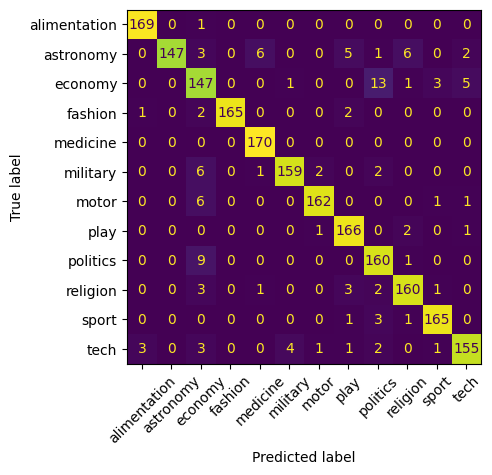

OK → models/nb_tfidf.joblib y figures/confusion_nb.png


In [17]:
nb_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2)),
    ("clf", MultinomialNB())
])

nb_pipe.fit(X_train, y_train)
pred_nb = nb_pipe.predict(X_test)

acc_nb = accuracy_score(y_test, pred_nb)
f1_nb  = f1_score(y_test, pred_nb, average="macro")

print(f"[NB] accuracy={acc_nb:.4f}  f1_macro={f1_nb:.4f}")
print("\n[NB] classification_report:\n", classification_report(y_test, pred_nb, zero_division=0))

cm_nb = confusion_matrix(y_test, pred_nb, labels=sorted(set(labels)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=sorted(set(labels)))
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, xticks_rotation=45, colorbar=False)
plt.tight_layout(); plt.savefig("figures/confusion_nb.png", dpi=160); plt.show()

joblib.dump(nb_pipe, "models/nb_tfidf.joblib")
print("OK → models/nb_tfidf.joblib y figures/confusion_nb.png")

[SVM] accuracy=0.9647  f1_macro=0.9647

[SVM] classification_report:
               precision    recall  f1-score   support

alimentation       0.99      0.99      0.99       170
   astronomy       0.98      0.97      0.98       170
     economy       0.89      0.88      0.88       170
     fashion       0.99      0.98      0.99       170
    medicine       0.98      1.00      0.99       170
    military       0.98      0.99      0.99       170
       motor       0.99      0.98      0.99       170
        play       0.96      1.00      0.98       170
    politics       0.90      0.95      0.92       170
    religion       0.98      0.93      0.95       170
       sport       0.98      0.98      0.98       170
        tech       0.97      0.92      0.94       170

    accuracy                           0.96      2040
   macro avg       0.97      0.96      0.96      2040
weighted avg       0.97      0.96      0.96      2040



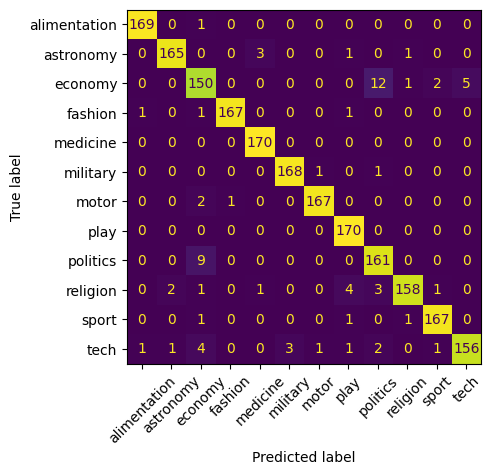

OK → models/svm_tfidf.joblib y figures/confusion_svm.png


In [18]:
svm_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2)),
    ("clf", LinearSVC())
])

svm_pipe.fit(X_train, y_train)
pred_svm = svm_pipe.predict(X_test)

acc_svm = accuracy_score(y_test, pred_svm)
f1_svm  = f1_score(y_test, pred_svm, average="macro")

print(f"[SVM] accuracy={acc_svm:.4f}  f1_macro={f1_svm:.4f}")
print("\n[SVM] classification_report:\n", classification_report(y_test, pred_svm, zero_division=0))

cm_svm = confusion_matrix(y_test, pred_svm, labels=sorted(set(labels)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=sorted(set(labels)))
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, xticks_rotation=45, colorbar=False)
plt.tight_layout(); plt.savefig("figures/confusion_svm.png", dpi=160); plt.show()

joblib.dump(svm_pipe, "models/svm_tfidf.joblib")
print("OK → models/svm_tfidf.joblib y figures/confusion_svm.png")

In [19]:
import json

summary = {
    "NB":  {"accuracy": float(acc_nb),  "f1_macro": float(f1_nb)},
    "SVM": {"accuracy": float(acc_svm), "f1_macro": float(f1_svm)}
}
print("Resumen:", summary)

with open("data/processed/classif_summary.json","w",encoding="utf-8") as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

errs = [(i, y_test[i], pred_svm[i], X_test[i]) for i in range(len(X_test)) if pred_svm[i] != y_test[i]]
print(f"Errores SVM: {len(errs)}")
for i,(idx, y, yhat, txt) in enumerate(errs[:10], 1):
    print(f"\n[{i}] true={y} pred={yhat}\n{txt[:300]}...")

Resumen: {'NB': {'accuracy': 0.9436274509803921, 'f1_macro': 0.9438479849044468}, 'SVM': {'accuracy': 0.9647058823529412, 'f1_macro': 0.964667993208023}}
Errores SVM: 72

[1] true=astronomy pred=play
un enorme tornado succiona en el oceano a cientos de tiburones hambrientos que amenazan con devorarlo todo a su paso por la ciudad de los angeles.este es el delirante argumento de "sharknado", una pelicula que tras su estreno hace unas semanas en la television de estados unidos desato una tormenta e...

[2] true=astronomy pred=religion
las autoridades australianas informaron que un hombre fallecio tras ser atacado presuntamente por un tiburon en una playa de bryon bay, el punto mas oriental del continente australiano.el sujeto fue mordido en una pierna mientras se encontraba en un popular destino turistico en nueva gales del sur y...

[3] true=fashion pred=economy
agentes de la policia nacional han bloqueado paginas web que clonaban los portales de marcas de ropa de reconocido prestigio, p

In [20]:
loaded = joblib.load("models/svm_tfidf.joblib") 
ejemplos = [
    "El gobierno anunció nuevas medidas económicas para el próximo trimestre.",
    "Resultados financieros positivos impulsan a la compañía en los mercados.",
]
print(loaded.predict(ejemplos))

['politics' 'economy']


# MLOPS

In [7]:
import os, json
os.makedirs("docs", exist_ok=True)

goals = {
    "optimizamos": "F1-macro",
    "metas": {
        "f1_macro_min": 0.94,           # meta del trabajo
        "f1_por_clase_min": 0.80,       # fairness simple
    },
    "sla_demo": {
        "latencia_p95_ms": 100          # objetivo académico en CPU
    }
}

with open("docs/objetivo_y_slas.json","w", encoding="utf-8") as f:
    json.dump(goals, f, indent=2, ensure_ascii=False)

print("OK → docs/objetivo_y_slas.json")
goals

OK → docs/objetivo_y_slas.json


{'optimizamos': 'F1-macro',
 'metas': {'f1_macro_min': 0.94, 'f1_por_clase_min': 0.8},
 'sla_demo': {'latencia_p95_ms': 100}}

In [8]:
import pandas as pd

path = "data/raw/dataset.csv"
df = pd.read_csv(path)

# 1) Columnas esperadas
assert {"text","label"}.issubset(df.columns), f"Columnas: {df.columns.tolist()}"

# 2) Nulos
assert df["text"].notna().all(), "Hay textos nulos"
assert df["label"].notna().all(), "Hay etiquetas nulas"

# 3) Longitud mínima
min_len_ok = df["text"].astype(str).str.len().ge(10).mean()
print(f"% textos con largo ≥10: {min_len_ok:.3f}")
assert min_len_ok > 0.95, "Demasiados textos muy cortos (<10)"

# 4) Duplicados
dup_rate = df["text"].duplicated().mean()
print(f"% textos duplicados: {dup_rate:.3f}")
assert dup_rate < 0.05, "Muchos duplicados (>5%)"

# 5) Distribución por clase (reporte)
dist = df["label"].value_counts(normalize=True).round(3)
print("Distribución por clase (proporción):")
print(dist)

print("\nOK: validaciones básicas superadas.")

% textos con largo ≥10: 1.000
% textos duplicados: 0.005
Distribución por clase (proporción):
label
play            0.083
tech            0.083
medicine        0.083
astronomy       0.083
sport           0.083
fashion         0.083
alimentation    0.083
politics        0.083
military        0.083
religion        0.083
motor           0.083
economy         0.083
Name: proportion, dtype: float64

OK: validaciones básicas superadas.


In [9]:
import json, os, numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Carga: usa preprocesado si existe
if os.path.exists("data/processed/preprocesado.parquet"):
    d = pd.read_parquet("data/processed/preprocesado.parquet").dropna(subset=["text_norm","label"])
    X = d["text_norm"].astype(str).to_numpy()
    y = d["label"].astype(str).to_numpy()
else:
    d = pd.read_csv("data/raw/dataset.csv").dropna(subset=["text","label"])
    X = d["text"].astype(str).to_numpy()
    y = d["label"].astype(str).to_numpy()

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2)),
    ("clf", LinearSVC())
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs, f1s = [], []
reports = []

for fold, (tr, te) in enumerate(skf.split(X, y), 1):
    pipe.fit(X[tr], y[tr])
    pred = pipe.predict(X[te])
    accs.append(accuracy_score(y[te], pred))
    f1s.append(f1_score(y[te], pred, average="macro"))
    reports.append(classification_report(y[te], pred, zero_division=0, output_dict=True))

summary = {
    "cv": 5,
    "accuracy_mean": float(np.mean(accs)),
    "accuracy_std":  float(np.std(accs)),
    "f1_macro_mean": float(np.mean(f1s)),
    "f1_macro_std":  float(np.std(f1s)),
}

# F1 medio por clase (promedio sobre folds)
all_labels = sorted({c for rep in reports for c in rep if c not in ("accuracy","macro avg","weighted avg")})
f1_por_clase = {}
for cls in all_labels:
    vals = [rep[cls]["f1-score"] for rep in reports if cls in rep]
    if vals:
        f1_por_clase[cls] = float(np.mean(vals))
summary["per_class_f1_mean"] = f1_por_clase

os.makedirs("data/processed", exist_ok=True)
with open("data/processed/cv_summary.json","w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

print("Resumen CV:", summary)

Resumen CV: {'cv': 5, 'accuracy_mean': 0.9582352941176471, 'accuracy_std': 0.0054444875987901395, 'f1_macro_mean': 0.9581735982152685, 'f1_macro_std': 0.005555091690292628, 'per_class_f1_mean': {'alimentation': 0.9860359547545727, 'astronomy': 0.9621320823578591, 'economy': 0.8833204930255014, 'fashion': 0.9731619092774455, 'medicine': 0.9849034618713404, 'military': 0.9707662728068115, 'motor': 0.9741336667483715, 'play': 0.9595188742694546, 'politics': 0.9374139483100429, 'religion': 0.9456156872423384, 'sport': 0.9859026654732297, 'tech': 0.935178162446254}}


In [11]:
import os, json, time
os.makedirs("data/processed", exist_ok=True)
log_path = "data/processed/exp_log.jsonl"

run = {
    "ts": time.strftime("%Y-%m-%d %H:%M:%S"),
    "model": "LinearSVC",
    "feats": "TFIDF(1,2), min_df=2",
    "cv": 5,
    "metrics": json.load(open("data/processed/cv_summary.json", "r", encoding="utf-8")),
}

with open(log_path, "a", encoding="utf-8") as f:
    f.write(json.dumps(run, ensure_ascii=False) + "\n")

print("OK → añadido run a", log_path)

OK → añadido run a data/processed/exp_log.jsonl


In [ ]:
import numpy as np, time, pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
import os

# Entrena un modelo rápido sobre todo el set (o usa el ya entrenado si lo tienes en memoria).
if os.path.exists("data/processed/preprocesado.parquet"):
    d = pd.read_parquet("data/processed/preprocesado.parquet").dropna(subset=["text_norm","label"])
else:
    d = pd.read_csv("data/raw/dataset.csv").dropna(subset=["text","label"])

texts = (d["text_norm"] if "text_norm" in d else d["text"]).astype(str).tolist()
labels = d["label"].astype(str).tolist()

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2)),
    ("clf", LinearSVC())
]).fit(texts, labels)

ejemplos = [
    "El gobierno anunció nuevas medidas económicas para el próximo trimestre.",
    "Resultados financieros positivos impulsan a la compañía en los mercados.",
    "El telescopio registró una nueva explosión solar visible desde Europa.",
]
samples = ejemplos * 70   # ~210 predicciones

# Warm-up
pipe.predict([ejemplos[0]])

times = []
for s in samples:
    t0 = time.perf_counter()
    _ = pipe.predict([s])[0]
    t1 = time.perf_counter()
    times.append((t1 - t0) * 1000.0)  # ms

p50 = float(np.percentile(times, 50))
p95 = float(np.percentile(times, 95))
print({"n_preds": len(times), "latencia_p50_ms": round(p50,2), "latencia_p95_ms": round(p95,2)})

{'n_preds': 210, 'latencia_p50_ms': 0.34, 'latencia_p95_ms': 0.56}


In [ ]:
import importlib, json

pkgs = ["pandas","numpy","scikit-learn","matplotlib","nltk","gensim","textdistance","spacy","typer","pyyaml","joblib"]
vers = {}
for p in pkgs:
    try:
        m = importlib.import_module(p)
        vers[p] = getattr(m, "__version__", "unknown")
    except Exception:
        vers[p] = "not_installed"

with open("requirements.txt","w") as f:
    for k,v in vers.items():
        if v == "not_installed":
            continue
        f.write(f"{k}=={v}\n")

print("Escrito requirements.txt con versiones detectadas.")
print(json.dumps(vers, indent=2, ensure_ascii=False))

Escrito requirements.txt con versiones detectadas.
{
  "pandas": "2.3.2",
  "numpy": "1.26.4",
  "scikit-learn": "not_installed",
  "matplotlib": "3.10.6",
  "nltk": "3.9.1",
  "gensim": "4.3.3",
  "textdistance": "4.6.2",
  "spacy": "3.8.7",
  "typer": "0.19.2",
  "pyyaml": "not_installed",
  "joblib": "1.5.2"
}


In [13]:
# Guarda latencia y verifica contra SLA (docs/objetivo_y_slas.json)
import os, json, time, numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
import pandas as pd

def quick_latency():
    if "pipe" in globals():
        clf = pipe
    else:
        if os.path.exists("data/processed/preprocesado.parquet"):
            d = pd.read_parquet("data/processed/preprocesado.parquet").dropna(subset=["text_norm","label"])
            texts = d["text_norm"].astype(str).tolist()
        else:
            d = pd.read_csv("data/raw/dataset.csv").dropna(subset=["text","label"])
            texts = d["text"].astype(str).tolist()
        labels = d["label"].astype(str).tolist()
        clf = Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2)), ("clf", LinearSVC())]).fit(texts, labels)

    ejemplos = [
        "El gobierno anunció nuevas medidas económicas para el próximo trimestre.",
        "Resultados financieros positivos impulsan a la compañía en los mercados.",
        "El telescopio registró una nueva explosión solar visible desde Europa.",
    ]
    samples = ejemplos * 70  # ~210 predicciones
    _ = clf.predict([ejemplos[0]])  # warm-up
    times = []
    for s in samples:
        t0 = time.perf_counter()
        _ = clf.predict([s])[0]
        t1 = time.perf_counter()
        times.append((t1 - t0) * 1000.0)  # ms
    return float(np.percentile(times, 50)), float(np.percentile(times, 95)), len(times)

try:
    p50_ms, p95_ms
except NameError:
    p50_ms, p95_ms, n_preds = quick_latency()
else:
    try:
        n_preds
    except NameError:
        n_preds = 210

lat = {"n_preds": int(n_preds), "latencia_p50_ms": round(p50_ms, 3), "latencia_p95_ms": round(p95_ms, 3)}
os.makedirs("data/processed", exist_ok=True)
with open("data/processed/latency_summary.json", "w") as f:
    json.dump(lat, f, indent=2)
print("OK → data/processed/latency_summary.json", lat)

goals = json.load(open("docs/objetivo_y_slas.json", "r", encoding="utf-8"))
sla_limit = goals["sla_demo"]["latencia_p95_ms"]
assert lat["latencia_p95_ms"] <= sla_limit, f"SLA NO cumplido (p95={lat['latencia_p95_ms']} ms > {sla_limit} ms)"
print(f"SLA OK: p95={lat['latencia_p95_ms']} ms ≤ {sla_limit} ms")


OK → data/processed/latency_summary.json {'n_preds': 210, 'latencia_p50_ms': 0.357, 'latencia_p95_ms': 0.468}
SLA OK: p95=0.468 ms ≤ 100 ms


In [14]:
import json

goals = json.load(open("docs/objetivo_y_slas.json","r", encoding="utf-8"))
cv = json.load(open("data/processed/cv_summary.json","r", encoding="utf-8"))

f1_macro = cv["f1_macro_mean"]
f1_target = goals["metas"]["f1_macro_min"]
assert f1_macro >= f1_target, f"Meta de F1-macro NO cumplida: {f1_macro:.4f} < {f1_target:.2f}"

per_cls = cv.get("per_class_f1_mean", {})
if per_cls:
    f1_min_cls = min(per_cls.values())
    f1_cls_target = goals["metas"]["f1_por_clase_min"]
    assert f1_min_cls >= f1_cls_target, f"Fairness NO cumplida: F1 mínima {f1_min_cls:.4f} < {f1_cls_target:.2f}"
    print(f"OK: F1-macro={f1_macro:.4f} (≥ {f1_target}), F1 mínima por clase={f1_min_cls:.4f} (≥ {f1_cls_target})")
else:
    print(f"OK: F1-macro={f1_macro:.4f} (≥ {f1_target}). *No se encontró F1 por clase*")


OK: F1-macro=0.9582 (≥ 0.94), F1 mínima por clase=0.8833 (≥ 0.8)


In [15]:
import os, json, time

lat = json.load(open("data/processed/latency_summary.json","r"))
cv  = json.load(open("data/processed/cv_summary.json","r"))

run = {
    "ts": time.strftime("%Y-%m-%d %H:%M:%S"),
    "model": "LinearSVC",
    "feats": "TFIDF(1,2), min_df=2",
    "cv": cv["cv"],
    "metrics": cv,
    "latency": lat,
}

log_path = "data/processed/exp_log.jsonl"
with open(log_path, "a", encoding="utf-8") as f:
    f.write(json.dumps(run, ensure_ascii=False) + "\n")
print("OK → añadido run con latencia a", log_path)


OK → añadido run con latencia a data/processed/exp_log.jsonl


In [16]:
import os, joblib, pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

# Usa texto preprocesado si existe
if os.path.exists("data/processed/preprocesado.parquet"):
    d = pd.read_parquet("data/processed/preprocesado.parquet").dropna(subset=["text_norm","label"])
    texts = d["text_norm"].astype(str).tolist()
else:
    d = pd.read_csv("data/raw/dataset.csv").dropna(subset=["text","label"])
    texts = d["text"].astype(str).tolist()
labels = d["label"].astype(str).tolist()

final_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2)),
    ("clf", LinearSVC())
]).fit(texts, labels)

os.makedirs("models", exist_ok=True)
joblib.dump(final_pipe, "models/svm_tfidf.joblib")
print("OK → models/svm_tfidf.joblib (modelo final guardado)")


OK → models/svm_tfidf.joblib (modelo final guardado)


Holdout → accuracy=0.9647  f1_macro=0.9647


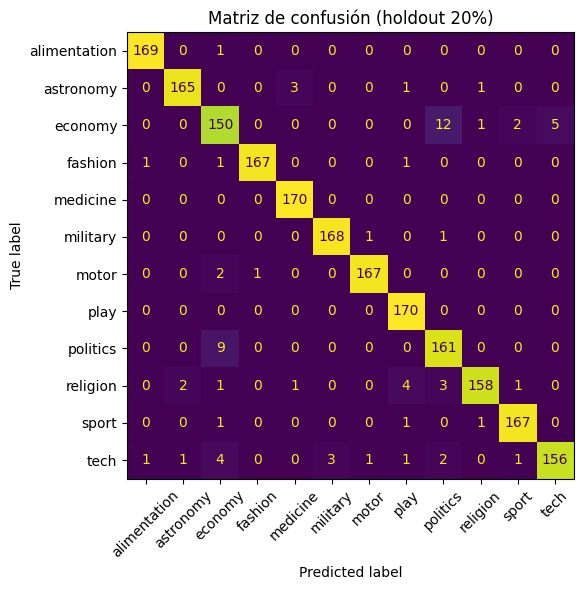

OK → figures/confusion_holdout.png


,true,pred,text
0,astronomy,play,un enorme tornado succiona en el oceano a cien...
1,astronomy,religion,las autoridades australianas informaron que un...
2,fashion,economy,agentes de la policia nacional han bloqueado p...
3,religion,astronomy,"el 11 de febrero, dia de la virgen de lourdes,..."
4,economy,tech,google sigue ampliando su proyecto de intelige...
5,religion,economy,la inteligencia artificial (ia) ya esta revolu...
6,religion,play,el de superman es uno de los papeles mas codic...
7,economy,sport,"el presidente de eeuu, joe biden, se mostro es..."
8,politics,economy,la tractorada que preve tomar madrid entre el ...
9,politics,economy,"llevaba trabajando para la empresa desde 1995,..."


In [17]:
import pandas as pd, numpy as np, os, matplotlib.pyplot as plt, joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Carga
if os.path.exists("data/processed/preprocesado.parquet"):
    df = pd.read_parquet("data/processed/preprocesado.parquet").dropna(subset=["text_norm","label"])
    X = df["text_norm"].astype(str).tolist()
else:
    df = pd.read_csv("data/raw/dataset.csv").dropna(subset=["text","label"])
    X = df["text"].astype(str).tolist()
y = df["label"].astype(str).tolist()

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
pipe = Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2)), ("clf", LinearSVC())]).fit(X_tr, y_tr)

pred = pipe.predict(X_te)
acc = accuracy_score(y_te, pred)
f1m = f1_score(y_te, pred, average="macro")
print(f"Holdout → accuracy={acc:.4f}  f1_macro={f1m:.4f}")

# Matriz de confusión
labels_sorted = sorted(set(y))
cm = confusion_matrix(y_te, pred, labels=labels_sorted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_sorted)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, xticks_rotation=45, colorbar=False)
plt.title("Matriz de confusión (holdout 20%)")
os.makedirs("figures", exist_ok=True)
plt.tight_layout(); plt.savefig("figures/confusion_holdout.png", dpi=160); plt.show()
print("OK → figures/confusion_holdout.png")

# 10 errores para el informe
errores = []
for i, (yt, yh, txt) in enumerate(zip(y_te, pred, X_te)):
    if yt != yh:
        errores.append({"true": yt, "pred": yh, "text": txt[:300] + ("..." if len(txt)>300 else "")})
    if len(errores) >= 10:
        break
pd.DataFrame(errores)


In [18]:
import os, json, pandas as pd

cv = json.load(open("data/processed/cv_summary.json","r", encoding="utf-8"))
lat = json.load(open("data/processed/latency_summary.json","r", encoding="utf-8"))
dist = df["label"].value_counts().rename_axis("label").to_frame("count")
dist["prop"] = (dist["count"] / dist["count"].sum()).round(3)

summary_rows = [{
    "metric": "CV_accuracy_mean", "value": cv["accuracy_mean"]
},{
    "metric": "CV_f1_macro_mean", "value": cv["f1_macro_mean"]
},{
    "metric": "CV_accuracy_std", "value": cv["accuracy_std"]
},{
    "metric": "CV_f1_macro_std", "value": cv["f1_macro_std"]
},{
    "metric": "latency_p50_ms", "value": lat["latencia_p50_ms"]
},{
    "metric": "latency_p95_ms", "value": lat["latencia_p95_ms"]
}]
summary_df = pd.DataFrame(summary_rows)

os.makedirs("data/processed", exist_ok=True)
summary_df.to_csv("data/processed/summary_metrics.csv", index=False)
dist.to_csv("data/processed/class_distribution.csv")
print("OK → data/processed/summary_metrics.csv  y  data/processed/class_distribution.csv")

summary_df, dist.head()


OK → data/processed/summary_metrics.csv  y  data/processed/class_distribution.csv


(             metric     value
 0  CV_accuracy_mean  0.958235
 1  CV_f1_macro_mean  0.958174
 2   CV_accuracy_std  0.005444
 3   CV_f1_macro_std  0.005555
 4    latency_p50_ms  0.357000
 5    latency_p95_ms  0.468000,
            count   prop
 label                  
 play         850  0.083
 tech         850  0.083
 medicine     850  0.083
 astronomy    850  0.083
 sport        850  0.083)

In [19]:
import joblib
clf = joblib.load("models/svm_tfidf.joblib")
ejemplos = [
    "El banco central evaluará nuevas medidas para contener la inflación.",
    "El delantero marcó dos goles en el partido de anoche.",
    "Una nova fue observada por astrónomos aficionados en el hemisferio sur.",
]
list(zip(ejemplos, clf.predict(ejemplos)))


[('El banco central evaluará nuevas medidas para contener la inflación.',
  'economy'),
 ('El delantero marcó dos goles en el partido de anoche.', 'sport'),
 ('Una nova fue observada por astrónomos aficionados en el hemisferio sur.',
  'astronomy')]

In [20]:
import os, random, numpy as np
random.seed(42)
np.random.seed(42)
os.environ["PYTHONHASHSEED"] = "42"
print("Semillas fijadas (random, numpy).")

Semillas fijadas (random, numpy).


In [21]:
import json, os
catalogo = {
    "preprocesamiento": {
        "lowercase": True, "strip_accents": True,
        "stopwords": "spanish", "digits_removed": True,
        "stemming": "Snowball(Spanish)", "lemmatization": "spaCy (si disponible)"
    },
    "representaciones": {
        "bow_tfidf": {"ngram_range": [1,2], "min_df": 2},
        "cooc_ppmi": {"window": 4, "min_count": 5},
        "word2vec": {"sg": 1, "vector_size": 100, "window": 5, "min_count": 5, "epochs": 5}
    },
    "clasificador": {"name": "LinearSVC", "features": "TF-IDF(1,2), min_df=2"}
}
os.makedirs("docs", exist_ok=True)
with open("docs/features_catalog.json","w", encoding="utf-8") as f:
    json.dump(catalogo, f, indent=2, ensure_ascii=False)
print("OK → docs/features_catalog.json")

OK → docs/features_catalog.json


In [22]:
import json, time, os, numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score

# Carga
if os.path.exists("data/processed/preprocesado.parquet"):
    d = pd.read_parquet("data/processed/preprocesado.parquet").dropna(subset=["text_norm","label"])
    X = d["text_norm"].astype(str).to_numpy()
else:
    d = pd.read_csv("data/raw/dataset.csv").dropna(subset=["text","label"])
    X = d["text"].astype(str).to_numpy()
y = d["label"].astype(str).to_numpy()

grid = [
    {"min_df": 1, "C": 1.0},
    {"min_df": 2, "C": 1.0},
    {"min_df": 2, "C": 0.5},
    {"min_df": 3, "C": 1.0},
]
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
results = []

for hp in grid:
    f1s = []
    for tr, te in skf.split(X, y):
        pipe = Pipeline([
            ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=hp["min_df"])),
            ("clf", LinearSVC(C=hp["C"]))
        ])
        pipe.fit(X[tr], y[tr])
        pred = pipe.predict(X[te])
        f1s.append(f1_score(y[te], pred, average="macro"))
    results.append({**hp, "f1_macro_mean": float(np.mean(f1s))})

results_sorted = sorted(results, key=lambda r: -r["f1_macro_mean"])
print("Sweep:", results_sorted)

# Log en exp_log.jsonl
os.makedirs("data/processed", exist_ok=True)
log_path = "data/processed/exp_log.jsonl"
for r in results_sorted:
    run = {
        "ts": time.strftime("%Y-%m-%d %H:%M:%S"),
        "model": "LinearSVC",
        "feats": f"TFIDF(1,2), min_df={r['min_df']}",
        "cv": 3, "params": {"C": r["C"]},
        "metrics": {"f1_macro_mean": r["f1_macro_mean"]}
    }
    with open(log_path, "a", encoding="utf-8") as f:
        f.write(json.dumps(run, ensure_ascii=False) + "\n")

Sweep: [{'min_df': 3, 'C': 1.0, 'f1_macro_mean': 0.9557678392128032}, {'min_df': 2, 'C': 1.0, 'f1_macro_mean': 0.9555647101020134}, {'min_df': 1, 'C': 1.0, 'f1_macro_mean': 0.9539809303334956}, {'min_df': 2, 'C': 0.5, 'f1_macro_mean': 0.9536701886943009}]


In [23]:
import os, json, glob, time, joblib
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
import pandas as pd

# Entrena con mejores hiperparámetros del sweep (ajusta si tuviste otro ganador)
min_df_best, C_best = 2, 1.0

if os.path.exists("data/processed/preprocesado.parquet"):
    d = pd.read_parquet("data/processed/preprocesado.parquet").dropna(subset=["text_norm","label"])
    texts = d["text_norm"].astype(str).tolist()
else:
    d = pd.read_csv("data/raw/dataset.csv").dropna(subset=["text","label"])
    texts = d["text"].astype(str).tolist()
labels = d["label"].astype(str).tolist()

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=min_df_best)),
    ("clf", LinearSVC(C=C_best))
]).fit(texts, labels)

os.makedirs("models", exist_ok=True)
registry_path = "models/registry.json"
reg = {"versions": []}
if os.path.exists(registry_path):
    reg = json.load(open(registry_path, "r", encoding="utf-8"))

version = len(reg["versions"]) + 1
model_path = f"models/svm_tfidf_v{version}.joblib"
joblib.dump(pipe, model_path)

entry = {
    "version": version,
    "path": model_path,
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "signature": {"input": "str(text)", "output": "str(label)"},
}
reg["versions"].append(entry)
with open(registry_path, "w", encoding="utf-8") as f:
    json.dump(reg, f, indent=2, ensure_ascii=False)

print(f"OK → registrado {model_path} (versión {version}).")

OK → registrado models/svm_tfidf_v1.joblib (versión 1).


In [24]:
import pandas as pd, joblib, os

def predict_csv(in_path, out_path, model_path=None):
    model_path = model_path or max([p for p in os.listdir("models") if p.endswith(".joblib")], key=lambda p: os.path.getmtime(os.path.join("models", p)))
    clf = joblib.load(os.path.join("models", model_path))
    df = pd.read_csv(in_path)
    assert "text" in df.columns, "El CSV debe tener columna 'text'."
    df["pred"] = clf.predict(df["text"].astype(str).tolist())
    df.to_csv(out_path, index=False)
    print(f"OK → {out_path} con {len(df)} filas. Modelo: {model_path}")


In [25]:
import os, json, pandas as pd, numpy as np, joblib

# 1) Distribución de etiquetas del set de entrenamiento (proxy de "baseline")
if os.path.exists("data/processed/preprocesado.parquet"):
    base = pd.read_parquet("data/processed/preprocesado.parquet")["label"].astype(str)
else:
    base = pd.read_csv("data/raw/dataset.csv")["label"].astype(str)

base_dist = (base.value_counts(normalize=True)).sort_index()

# 2) Predicciones "producción" (usa data/prod si existe; si no, usa un bootstrap del test)
prod_csv = "data/prod/incoming.csv"
if os.path.exists(prod_csv):
    latest_model = sorted([p for p in os.listdir("models") if p.endswith(".joblib")], key=lambda p: os.path.getmtime(os.path.join("models", p)))[-1]
    clf = joblib.load(os.path.join("models", latest_model))
    prod = pd.read_csv(prod_csv)
    preds = pd.Series(clf.predict(prod["text"].astype(str).tolist()))
else:
    # Fallback: usa 20% del dataset como “simulación”
    df = pd.read_csv("data/raw/dataset.csv").sample(frac=0.2, random_state=42)
    latest_model = sorted([p for p in os.listdir("models") if p.endswith(".joblib")], key=lambda p: os.path.getmtime(os.path.join("models", p)))[-1]
    clf = joblib.load(os.path.join("models", latest_model))
    preds = pd.Series(clf.predict(df["text"].astype(str).tolist()))

pred_dist = (preds.value_counts(normalize=True)).sort_index()

# 3) PSI (Population Stability Index) entre distribuciones (simple)
labels_union = sorted(set(base_dist.index) | set(pred_dist.index))
p = np.array([base_dist.get(lbl, 1e-6) for lbl in labels_union])
q = np.array([pred_dist.get(lbl, 1e-6) for lbl in labels_union])
psi = float(np.sum((p - q) * np.log((p + 1e-12) / (q + 1e-12))))

report = {
    "labels": labels_union,
    "base_dist": {k: float(base_dist.get(k, 0.0)) for k in labels_union},
    "pred_dist": {k: float(pred_dist.get(k, 0.0)) for k in labels_union},
    "psi": psi
}
os.makedirs("data/processed", exist_ok=True)
with open("data/processed/drift_report.json","w", encoding="utf-8") as f:
    json.dump(report, f, indent=2, ensure_ascii=False)
print("Drift PSI:", psi, "→ data/processed/drift_report.json")

# 4) Gatillo de retraining (usa umbrales de tu JSON de metas + SLA y fairness)
goals = json.load(open("docs/objetivo_y_slas.json","r", encoding="utf-8"))
cv = json.load(open("data/processed/cv_summary.json","r", encoding="utf-8"))
lat = json.load(open("data/processed/latency_summary.json","r", encoding="utf-8"))

reasons = []
if cv.get("per_class_f1_mean"):
    if min(cv["per_class_f1_mean"].values()) < goals["metas"]["f1_por_clase_min"]:
        reasons.append("f1_min_por_clase_bajo")
if cv["f1_macro_mean"] < goals["metas"]["f1_macro_min"]:
    reasons.append("f1_macro_bajo")
if lat["latencia_p95_ms"] > goals["sla_demo"]["latencia_p95_ms"]:
    reasons.append("sla_latencia_incumplido")
if psi > 0.2:  # 0.1–0.2 leve; >0.2 moderado; >0.35 alto (regla de pulgar)
    reasons.append("drift_moderado_o_mayor")

flag = {"retrain": bool(reasons), "reasons": reasons}
with open("data/processed/retrain_flag.json","w", encoding="utf-8") as f:
    json.dump(flag, f, indent=2, ensure_ascii=False)
print("Retrain flag:", flag)

Drift PSI: 0.003900025239241605 → data/processed/drift_report.json
Retrain flag: {'retrain': False, 'reasons': []}
